In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [2]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [3]:
from lib.cgamma_biweight_log_mpe_prob import c_multi_gamma_biweight_mpe_logprob
from lib.c_mpe_gamma import c_multi_gamma_mpe_prob_midpoint, c_multi_gamma_mpe_prob_pure_jax
from lib.cgamma import c_multi_gamma_sf, c_multi_gamma_prob

In [4]:
convolved_mpe_biweight_v1d_x = jax.jit(jax.vmap(c_multi_gamma_biweight_mpe_logprob, (0, None, None, None, None, None), 0))
convolved_post_mpe_approx_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_midpoint, (0, None, None, None, None, None), 0))
convolved_post_mpe_exact_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax, (0, None, None, None, None, None), 0))
convolved_cgamma_sf_v1d_x = jax.jit(jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0))
convolved_cgamma_prob_v1d_x = jax.jit(jax.vmap(c_multi_gamma_prob, (0, None, None, None, None), 0))

In [5]:
dist = 5
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[1.00323282 3.4648285  1.00002434] [0.03936591 1.99967647 0.00243112]


In [6]:
@jax.jit
def convolved_cgamma_mpe_prob(x, mix_probs, a, b, n, sigma=3.0):
    probs = convolved_cgamma_prob_v1d_x(x, mix_probs, a, b, jnp.array(3.0))
    sfs_pn = jnp.power(convolved_cgamma_sf_v1d_x(x, mix_probs, a, b, jnp.array(3.0)), n-1)
    ys = n * probs * sfs_pn
    return ys
    

[nan nan nan nan nan nan nan nan nan nan]
[5.72377299e-24 5.73924060e-24 5.75474960e-24 5.77030011e-24
 5.78589223e-24 5.80152606e-24 5.81720173e-24 5.83291934e-24
 5.84867901e-24 5.86448084e-24]
[6.06400143e-24 6.08039241e-24 6.09682726e-24 6.11330610e-24
 6.12982904e-24 6.14639621e-24 6.16300772e-24 6.17966369e-24
 6.19636423e-24 6.21310946e-24]
[1.45118264e-23 1.45513770e-23 1.45910344e-23 1.46307989e-23
 1.46706706e-23 1.47106500e-23 1.47507374e-23 1.47909329e-23
 1.48312369e-23 1.48716497e-23]


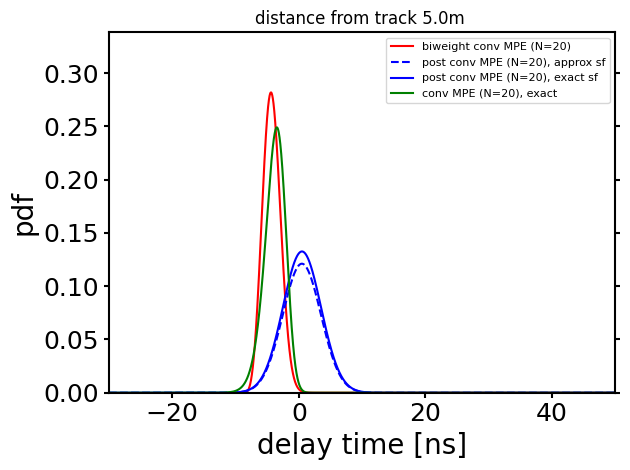

In [14]:
from matplotlib.pyplot import cm

n_p = 20

fig, ax = plt.subplots()
xvals = np.linspace(-30, 50, 100000)

y_max = 0
ys = jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))
plt.plot(xvals, ys, label=f'biweight conv MPE (N={n_p:.0f})', color='red', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_approx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), approx sf', color='blue', linestyle='dashed')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_post_mpe_exact_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'post conv MPE (N={n_p:.0f}), exact sf', color='blue', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])

ys = convolved_cgamma_mpe_prob(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))
plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f}), exact', color='green', linestyle='solid')
y_max = np.amax([y_max, np.nanmax(ys)])
print(ys[:10])



plot_args = {'xlim':[-30, 50],
                     'ylim':[0.0, 1.2*y_max],
                     #'ylim':[0.0, 0.5],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m ")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [8]:
%timeit jnp.exp(convolved_mpe_biweight_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0)))

5.1 ms ± 8.63 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit convolved_post_mpe_approx_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

11.5 ms ± 3.48 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit convolved_post_mpe_exact_v1d_x(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

124 ms ± 384 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit convolved_cgamma_mpe_prob(xvals, mix_probs, g_a, g_b, n_p, jnp.array(3.0))

45.5 ms ± 44 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
